## Importacion de paquetes y configuración de Spark

Se importan los paquetes de python necesarios

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, abs as pysAbs, min as pysMin, max as pysMax, sum as pysSum
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Configuración del controlador e inicio de sesion Spark

In [2]:
import os
import sys

# asegurar que todos los componentes de Spark utilicen el mismo intérprete de Python que se esta ejecutando en el notebook
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

#path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'
#path_jar_driver = 'C:\Program Files\MySQL\MySQL Workbench 8.0 CE\Connector J 8.0\mysql-connector-j-8.3.0.jar'
path_jar_driver = 'C:\Program Files\MySQL\MySQL Workbench 8.0 CE\Connector J 8.0\mysql-connector-java-8.0.28.jar'
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

# esta linea permite a spark utlizar e l parser de tiempo anterior a al versión 3.0, y evita un problema con el análisis de fecha y hora
# Exception: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2015-12-02 12:00:00.0000000' in the new parser.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") 

# Conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.120:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_15_202413'
db_psswd = 'aabb1122'

PATH='./'

C:\Users\jpmog\anaconda3\envs\CursoETL\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## Perfilamiento de los datos

### Conexion a la fuente de datos y acceso a los datos

#### Conexión a la fuente de datos

In [3]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Acceso a los datos

In [31]:
# Leer la hoja 'data01' del archivo Excel usando pandas
excel_file = 'C:/Users/jpmog/OneDrive/Documents/LFOC/Sanofi/Diabetes_Franchise_Dashboard.v1 (3).xlsx'
df_eps = pd.read_excel(excel_file, sheet_name='Data01')
df_ips = pd.read_excel(excel_file, sheet_name='Data02')

In [22]:
df_eps

,EPS / Asegurador,SAM,# Afiliados,% of Contributive reg,% of Subsidized reg,# Patientes Diabeticos (Mayores 18 años),% Patientes Insulinizados,% Pacientes controlados,Nombre del decisor para la inclusión de moleculas o modificación del protocolo,Cual es su especialización?,...,Se inicia en pacientes naive,Se inicia en pacientes despues de uso de antidiabeticos orales?.1,Se inicia en pacientes no controlados de basal-bolo?,Se usa Gla-300U en free-combo?,"Si no se usa Gla-300, Cual es la insulina incluida por HCP?",Objeción 1,Objeción 2.1,Objectión 3,Necesita documentos o procesos adicionales para autorizar o dispensar?.1,Quien realiza la dispensación?.1
0,NUEVA EPS,Juan Carlos Yepes Acevedo,11188007.0,0.44,0.56,392699.0,0.22,0.436,Dra Laila Tamer / Dr Johnny Beltran,Internista,...,Not,Yes,Yes,Yes,NaN,Esta en primera opcion por lineamiento y por a...,NaN,NaN,Not,Los 6 OL
1,SURA,Victor Vergara Polo,5456245.0,0.85,0.15,NaN,NaN,NaN,Dr Alex Ramirez / Comité de medicamentos Sura ...,Endocrinologo,...,Not,Yes,Yes,Yes,U100,NaN,NaN,NaN,Yes,COLSUBSIDIO-IPS SURAMERICANA (IPS ESPECIALIZAD...
2,SANITAS,Diana Avila,5683869.0,0.75,0.25,NaN,NaN,0.48,Dr Nancy Yomayuza / Alcibiades,HCP Administrativo,...,Not,Yes,Yes,NaN,se inicia con insulina U100 para ecalonar con ...,La principal objecion es el costo y el despard...,NaN,NaN,Not,Cruz verde / Discolmedica
3,SALUD TOTAL,Carlos Castillo,4941620.0,0.69,0.31,274896.0,0.27,0.63,Sandra Rodriguez,HCP Administrativo,...,Yes,Yes,Yes,Yes,lantus,Se requieren más unidades de Toujeo vs otras i...,NaN,NaN,Yes,Audifarma
4,COOSALUD,Hassib Cepeda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,FAMISANAR,Sandra Milena Cifuentes Rojas,2817124.0,0.68,0.32,37250.0,0.27,0.49,Dra Saidi Osorio / Esmeralda Martínez,HCP Administrativo,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,Not,Colsubsidio - Cafam
6,MUTUAL SER,Hassib Cepeda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,COMPENSAR,Alexis Romero,2133642.0,0.82,0.18,85700.0,0.17,NaN,miguel omeara,Endocrinologo,...,Not,Yes,Yes,Yes,NaN,NaN,NaN,NaN,Not,Audifarma/evedisa/cv
8,ASMET SALUD,Natalia Bastidas Hleap,1611751.0,0.04,0.96,31696.0,0.00,0.57,GLADIS ALCARAZ,dir gestión farmaceútica,...,Not,Not,Yes,Yes,Xultophy,,,,OPS,UT
9,EMSSANAR,Natalia Bastidas Hleap,1752883.0,0.06,0.94,54325.0,0.00,0.52,Nancy Caicedo,Enfermera,...,si depediendo de la red,Yes,Yes,Yes,Xultophy,,,,OPS,"Farmart, Megafarma"


In [24]:
ips_t = df_eps

# Duplicar las columnas 'EPS / Asegurador' y 'SAM'
ips_t['EPS'] = ips_t['EPS / Asegurador']
ips_t['SAM_Name'] = ips_t['SAM']
column_order = ['EPS', 'SAM_Name'] + [col for col in ips_t.columns if col not in ['EPS', 'SAM_Name']]
ips_t = ips_t[column_order]

columns_to_exclude = ['EPS', 'SAM_Name']

# Aplicar la transformación a cada columna excepto las excluidas
for col in ips_t.columns:
    if col not in columns_to_exclude:
        ips_t[col] = ips_t[col].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)

ips_t['Columnas_Completas'] = ips_t.sum(axis=1)

num_columns = len([col for col in ips_t.columns if col not in columns_to_exclude + ['Columnas_Completas']])

ips_t['Total_columnas'] = num_columns

ips_t['completitud_de_fila'] = ips_t['Total_columnas'] / num_columns

output_file = 'C:/Users/jpmog/OneDrive/Documents/LFOC/Sanofi/DFD_Transformed_EPS.xlsx'
ips_t.to_excel(output_file, index=False)

ips_t

C:\Users\jpmog\anaconda3\envs\CursoETL\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()


,EPS,SAM_Name,EPS / Asegurador,SAM,# Afiliados,% of Contributive reg,% of Subsidized reg,# Patientes Diabeticos (Mayores 18 años),% Patientes Insulinizados,% Pacientes controlados,...,Se usa Gla-300U en free-combo?,"Si no se usa Gla-300, Cual es la insulina incluida por HCP?",Objeción 1,Objeción 2.1,Objectión 3,Necesita documentos o procesos adicionales para autorizar o dispensar?.1,Quien realiza la dispensación?.1,Columnas_Completas,Total_columnas,completitud_de_fila
0,NUEVA EPS,Juan Carlos Yepes Acevedo,1,1,1,1,1,1,1,1,...,1,0,1,0,0,1,1,37,42,1.0
1,SURA,Victor Vergara Polo,1,1,1,1,1,0,0,0,...,1,1,0,0,0,1,1,34,42,1.0
2,SANITAS,Diana Avila,1,1,1,1,1,0,0,1,...,0,1,1,0,0,1,1,34,42,1.0
3,SALUD TOTAL,Carlos Castillo,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,1,37,42,1.0
4,COOSALUD,Hassib Cepeda,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,42,1.0
5,FAMISANAR,Sandra Milena Cifuentes Rojas,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,34,42,1.0
6,MUTUAL SER,Hassib Cepeda,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,42,1.0
7,COMPENSAR,Alexis Romero,1,1,1,1,1,1,1,0,...,1,0,0,0,0,1,1,33,42,1.0
8,ASMET SALUD,Natalia Bastidas Hleap,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,42,42,1.0
9,EMSSANAR,Natalia Bastidas Hleap,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,42,42,1.0


In [32]:
ips_t = df_ips

# Duplicar las columnas 'EPS / Asegurador' y 'SAM'
ips_t['IPS_'] = ips_t['IPS']
ips_t['KAD_'] = ips_t['KAD']
ips_t['EPS'] = ips_t['Cual EPS']
column_order = ['IPS_', 'KAD_', 'EPS'] + [col for col in ips_t.columns if col not in ['IPS_', 'KAD_','EPS']]
ips_t = ips_t[column_order]

columns_to_exclude = ['IPS_', 'KAD_', 'EPS']

# Aplicar la transformación a cada columna excepto las excluidas
for col in ips_t.columns:
    if col not in columns_to_exclude:
        ips_t[col] = ips_t[col].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)

ips_t['Columnas_Completas'] = ips_t.sum(axis=1)

num_columns = len([col for col in ips_t.columns if col not in columns_to_exclude + ['Columnas_Completas']])

ips_t['Total_columnas'] = num_columns

ips_t['completitud_de_fila'] = ips_t['Total_columnas'] / num_columns

output_file = 'C:/Users/jpmog/OneDrive/Documents/LFOC/Sanofi/DFD_Transformed_IPS_1.xlsx'
ips_t.to_excel(output_file, index=False)

ips_t

C:\Users\jpmog\anaconda3\envs\CursoETL\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,IPS_,KAD_,EPS,IPS,La IPS es exclusiva de una EPS?,Cual EPS,KAD,# Población asignada a la IPS,# Pacientes Diabeticos (Mayores de 18 años),% Patientes Insulinizados,...,Se inicia en pacientes no controlados de basal-bolo?,Se usa Gla-300U en free-combo?,"Si no se usa Gla-300, Cual es la insulina incluida por HCP?",Necesita documentos o procesos adicionales para autorizar o dispensar?.1,Quien realiza la dispensación?.1,Objeción 1.1,Objeción 2.1,Columnas_Completas,Total_columnas,completitud_de_fila
0,Viva 1A Bogotá,YENNY PINEDA,NUEVA EPS,1,1,1,1,1,0,0,...,1,1,1,1,1,1,0,29,39,1.0
1,Bienestar Bogotá,YENNY PINEDA,NUEVA EPS,1,1,1,1,0,0,0,...,1,1,1,1,1,1,0,27,39,1.0
2,Hospital Universitario Mederi,YENNY PINEDA,NaN,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,3,39,1.0
3,Hospital San Rafael,YENNY PINEDA,NaN,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,3,39,1.0
4,Clinica Nueva El Lago,YENNY PINEDA,NUEVA EPS,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,4,39,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,IPS VIVIR,BEATRIZ QUINTERO,SURA EPS,1,1,1,1,0,0,0,...,1,1,1,1,1,0,0,30,39,1.0
182,CM SANITAS VERSALLES,BEATRIZ QUINTERO,EPS Sanitas,1,1,1,1,0,0,0,...,1,1,1,1,1,0,0,31,39,1.0
183,CM SANITAS TEQUENDAMA,BEATRIZ QUINTERO,EPS Sanitas,1,1,1,1,0,0,0,...,1,1,1,1,1,0,0,31,39,1.0
184,GESENCRO,BEATRIZ QUINTERO,EMSSANAR,1,1,1,1,0,0,0,...,1,1,1,1,1,0,0,30,39,1.0


### Entendimiento general de los datos

#### Diccionario de datos
> **Tabla:** movimientosCopia
> * **Columna: Descripcion**
> * TransaccionProductoID: Llave primaria que identifica
> * ProductoID: Llave foranea que hace la relación con la tabla producto, representa el producto que fue extraido o agregado en el inventario
> * TipoTransaccionID: Llave foranea que hace la relación con la tabla TipoTransaccion, representa el tipo de transaccion del movimiento
> * ClienteID: Llave foranea que hace la relación con la tabla Cliente, representa el cliente que hace la compra
> * InvoiceID: Identificador de la factura
> * ProveedorID: Llave foranea que hace la relación con la tabla Proveedor, representa el proveedor del producto en movimiento
> * OrdenDeCompraID: Llave foranea que hace la relación con la tabla de Ordenes, representa el id de la orden de este movimiento
> * FechaTransaccion: Fecha del movimiento en inventario
> * Cantidad: Cantidad de productos que se retiraron/ingresaron a inventario
>
> **Tabla:** TiposTransaccion
> * TipoTransaccionID: Llave primaria que identifica los tipos de transaccion
> * TipoTransaccionNombre: Nombre del tipo de transaccion

#### Vista preliminar de los datos

In [7]:
movimientos.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+------------------------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|FechaTransaccionAjustada|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+------------------------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|              2014-04-25|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|              2015-12-10|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|              2015-12-04|
|               290145|       213|               10|     33.0|  60795.0|           |    

In [8]:
tipoTransaccion.show(truncate=False)

+-----------------+-----------------------------+
|TipoTransaccionID|TipoTransaccionNombre        |
+-----------------+-----------------------------+
|2                |Customer Credit Note         |
|3                |Customer Payment Received    |
|4                |Customer Refund              |
|5                |Supplier Invoice             |
|6                |Supplier Credit Note         |
|7                |Supplier Payment Issued      |
|8                |Supplier Refund              |
|9                |Stock Transfer               |
|10               |Stock Issue                  |
|11               |Stock Receipt                |
|12               |Stock Adjustment at Stocktake|
|13               |Customer Contra              |
+-----------------+-----------------------------+



**Observaciones:** 
La tabla *movimientosCopia* contiene información relacionada con las transacciones (movimientos) de inventario, el cliente, el proveedor y la factura. Cada transacción esta identificada con un ID único: *TransaccionProductoID*, y contiene los identificadores de producto: *ProductoID*, cliente: *ClienteID*, factura:*InvoiceID*, proveedor:*ProveedorID* y orden de compra:*OrdenDeCompraID*. Además del tipo y fecha de transacción y la cantidad de producto que se movió en cada transacción (*TipoTransaccionID, FechaTransaccion, Cantidad*). 

La tabla *tipoTransaccion* contiene una descripción corta del tipo de transacción (movimiento) de inventario realizado. Para entender mejor el tipo de movimiento se sugiere solicitar al cliente una definición de cada uno de los tipos de transacción. 

In [9]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true),StructField(FechaTransaccionAjustada,DateType,true)))

**Observaciones:** 
Se identifica que la clave primaria de la tabla movimientosCopia es de tipo Integer, al igual que las claves foraneas que identifican el producto y el tipo de transacción; mientras que las calves foraneas que identifican al cliente y la factura son tipo Double, y las de proveedor y ordenes de compra de tipo String. La columna fecha tiene tipo de dato String y no Date, y el tipo de dato de la columna cantidad es Double. 

**¿Qué es una fila de cada fuente compartida?**
> De acuerdo con la exploración de datos realizada hasta ahora podemos concluir que cada fila en la tabla *movimientosCopia* representa el movimiento de inventario de un producto determinado realizado desde o hacia un cliente o proveedor en una fecha específica y por una cantidad especificada del producto (más adelante debe confirmarse si el signo de la cantidad representa un movimiento de entrada o salida de inventario); adicionalmente identifica el documento factura u orden de compra asociada a esa transacción. Por otro lado una fila de la tabla *tipoTransaccion* contiene la descripción o nombre del tipo de movimiento de inventario realizado. 

In [10]:
print((movimientos.count(), len(movimientos.columns)),(tipoTransaccion.count(), len(tipoTransaccion.columns)))

(204292, 10) (12, 2)


**¿Cuantos datos nos compartieron para el proyecto?**
> Se encontraron disponibles 204.292 movimientos de inventario, cerca de 32 mil menos que los reportados por el cliente. Adicionalmente se encuentran disponibles 12 tipos de transacciones. Se identifican 11 variables, 9 de las cuales corresponden a las llaves primarias o foraneas de las tablas, y dos a información relacionada con el momviento de inventario: fecha (en formato String) y cantidad.

### Revisión de reglas e información de negocio 

####  La cantidad máxima de productos movidos es 50 millones por transacción

In [11]:
texto = 'Número de transacciones con cantidad mayor a 50 millones: '
print(texto+str(movimientos.filter(pysAbs(col('Cantidad'))>50e6).count()))

# Calcular el valor absoluto de la columna 'Cantidad'
movimientos_con_abs = movimientos.withColumn("Cantidad_abs", pysAbs(col("Cantidad")))

# Obtener el valor máximo del valor absoluto de la columna 'Cantidad'
max_abs_cantidad = movimientos_con_abs.agg({"Cantidad_abs": "max"}).collect()[0][0]

print('En número máximo de unidades en una transacción es: ' +str(max_abs_cantidad))

Número de transacciones con cantidad mayor a 50 millones: 0
En número máximo de unidades en una transacción es: 67368.0


In [12]:
# Combinar con la tabla 'Producto' para traer del producto y el precio
movimientos = movimientos.join(Productos, movimientos["ProductoID"] == Productos["ID_Producto"]) \
                .select(movimientos["*"], Productos["NombreProducto"], Productos["PrecioUnitario"], Productos["PrecioRecomendado"])
# Calcular precio total de la transacción para las dos opciones de precio
movimientos = movimientos.withColumn(
    'ValorTotal_Con_PrecioUnitario',
       f.abs(col('PrecioUnitario')*col('Cantidad')),
).withColumn(
    'ValorTotal_Con_PrecioRecomendado',
   f.abs(col('PrecioRecomendado')*col('Cantidad')),
)

# Obtener el valor máximo de la transacción para las dos opciones de precio
max_precio1 = movimientos.agg({"ValorTotal_Con_PrecioUnitario": "max"}).collect()[0][0]
max_precio2 = movimientos.agg({"ValorTotal_Con_PrecioRecomendado": "max"}).collect()[0][0]

print('Precio máximo de una transacción según precio unitario es: ' +str(max_precio1))
print('Precio máximo de una transacción según precio recomendado es: ' +str(max_precio2))

Precio máximo de una transacción según precio unitario es: 1038400.0
Precio máximo de una transacción según precio recomendado es: 1557600.0


**Observaciones:** Todos los registros cumplen la regla de negocio, y no se encontraron transacciones por más de 50 millones de unidades del producto, y tampoco para ninguna de las opciones de precio identificadas en la tabla productos. Sin embargo, llama la atención que la cantidad máxima de producto que se mueve en una transacción es menor a 70 mil, y en valor es menor a 1.6 millones, por lo que el valor de la regla de negocio parace desproporcionado. Debe solicitarse al negocio que aclare si el valor de 50 millones corresponde a la cantidad de producto o al monto (valor) de la transacción. 

#### El formato de fechas manejado es YYYY-MM-DD HH:MM:SS

In [13]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato de fecha correcto: "+str(cumplenFormato.count()))

Número total de movimientos: 204292, número de movimientos con formato de fecha correcto: 140038


In [14]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 30,2015|
|     Apr 13,2015|
|     May 13,2016|
|     Apr 02,2015|
|     Apr 01,2015|
|     Feb 22,2014|
|     Jun 04,2015|
|     Feb 26,2015|
|     Feb 07,2014|
|     Apr 10,2015|
|     Jul 14,2014|
|     Nov 04,2015|
|     Dec 31,2015|
|     Feb 11,2014|
|     Aug 14,2014|
|     Mar 05,2015|
|     Apr 29,2016|
|     Aug 17,2015|
|     Apr 22,2014|
|     Jul 28,2015|
+----------------+
only showing top 20 rows



(64254, None)

In [15]:
#\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) \d{2},\d{4}\b
regex = "(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) (0[1-9]|[1-2][0-9]|3[0-1]),[0-2]\d{3}"
cumplenFormato2 = noCumplenFormato.filter(noCumplenFormato["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(noCumplenFormato.count())+", número de movimientos con formato de fecha alterno: "+str(cumplenFormato2.count()))

Número total de movimientos: 64254, número de movimientos con formato de fecha alterno: 64254


**Observaciones:** Del total de registros 64.254 no cumplen con el formato de fecha específicado. Los valores que no cumplen tienen un formato diferente que también corresponde a un formato de fecha valida. Dado que ambos formatos se pueden estandarizar, se informara al negocio de este hallazgo sin que se requiera un ajuste de su parte. 

**Los movimientos están relacionados con 228.265 clientes**

In [16]:
movimientos.select(col('ClienteID')).distinct().count()

664

**Observaciones:** En la tabla 'movimientosCopia' se registran transacciones relacionadas con 664 clientes únicos. Esta información no es coincidente con el número de clientes reportado por el negocio. Se debe solicitar aclaración de este dato. 

**Actualmente tenemos 13 proveedores**

In [17]:
movimientos.select(col('ProveedorID')).distinct().count()

4

**Observación:** El negocio menciona que cuenta con 13 proveedores, sin embargo, en la tabla 'movimientosCopia' se registran transacciones relacionadas solo con 4 proveedores distintos. Se debe solicitar aclaración al negocio de esta información. 

**Existen 236.668 movimientos de producto realizados desde 2013** 

In [18]:
movimientos.count(), movimientos.distinct().count()

(204292, 173659)

In [19]:
movimientos.select(col('TransaccionProductoID')).distinct().count()

173659

In [20]:
# Transformar fecha y estimar año
movimientos = movimientos.withColumn(
    'FechaTransaccionAjustada',
    f.coalesce(
        f.to_date(col('FechaTransaccion'), 'MMM dd,yyyy'),
        f.to_date(col('FechaTransaccion'), 'yyyy-MM-dd'),
        f.to_date(col('FechaTransaccion'), 'yyyy-MM-dd HH:mm:ss')
        
    )
).withColumn(
    'Año',
    f.year(col('FechaTransaccionAjustada'))
)

print("Movimientos por año")
pivotTable = movimientos.groupBy("Año").agg(f.count("*").alias("frecuencia")) \
    .orderBy("Año", ascending=False) 
pivotTable \
    .withColumn("frecuencia", f.format_number("frecuencia", 0)) \
    .show(10, truncate=False)

# Descartar registros duplicados
movimientosD = movimientos # Guardar copia de la base original de movimientos incluyendo duplicados
movimientos = movimientos.dropDuplicates()

print("Movimientos por año, sin duplicados")
pivotTable = movimientos.groupBy("Año").agg(f.count("*").alias("frecuencia")) \
    .orderBy("Año", ascending=False) 
pivotTable \
    .withColumn("frecuencia", f.format_number("frecuencia", 0)) \
    .show(10, truncate=False)

Movimientos por año
+----+----------+
|Año |frecuencia|
+----+----------+
|2016|35,828    |
|2015|87,590    |
|2014|80,533    |
|2013|341       |
+----+----------+

Movimientos por año, sin duplicados
+----+----------+
|Año |frecuencia|
+----+----------+
|2016|30,524    |
|2015|74,451    |
|2014|68,386    |
|2013|298       |
+----+----------+



**Observaciones:** La información entregada por el negocio no es consistente con la totalidad de movimientos informados. Se encontraron 204.292 registros, de los cuales 173.659 son únicos. El resto de los registros corresponderían a valores duplicados. Llama la atención el número de registros del año 2013 que en comparación con los otros años es mucho menor, 341 incluyendo duplicados, y 298 sin incluirlos, también es importante mencionar que el número de registros no duplicados del año 2016 no es consistente con el crecimiento esperado, 2014: 68 mil, 2015: 74 mil, 2016: 30 mil, lo que hace suponer que el último año esta incompleto. En este sentido es necesario informar de este hallazgo y consultar con negocio si les es posible completar la fuente de datos. 

### Análisis descriptivo
#### Estadísticas generales

+-------+-----------------+
|summary|         Cantidad|
+-------+-----------------+
|  count|           173659|
|   mean| 716.798081297255|
| stddev|4718.727053493452|
|    min|           -360.0|
|    25%|            -60.0|
|    50%|             -9.0|
|    75%|             -5.0|
|    max|          67368.0|
+-------+-----------------+



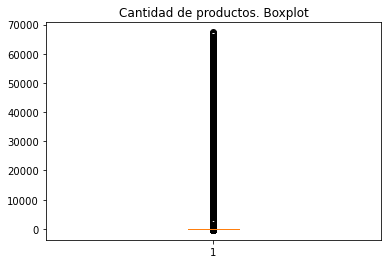

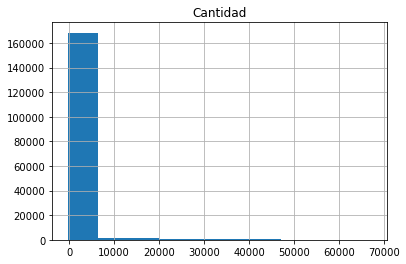


Percentiles de 'Cantidad'
5%: -150.0
10%: -108.0
15%: -90.0
20%: -72.0
25%: -60.0
30%: -48.0
35%: -30.0
40%: -20.0
45%: -10.0
50%: -9.0
55%: -8.0
60%: -7.0
65%: -6.0
70%: -5.0
75%: -5.0
80%: -4.0
85%: -3.0
90%: -2.0
95%: -1.0
97%: 6408.0
99%: 27336.0

Outliers por rango intercuartilico
Limite superior: 77.5, número registros atípicos: 5838
Limite inferior: 0.0, número registros atípicos: 10141

Percentiles de 'Cantidad_abs'
5%: 1.0
10%: 2.0
15%: 3.0
20%: 4.0
25%: 5.0
30%: 6.0
35%: 7.0
40%: 8.0
45%: 9.0
50%: 10.0
55%: 12.0
60%: 24.0
65%: 40.0
70%: 50.0
75%: 70.0
80%: 84.0
85%: 100.0
90%: 120.0
95%: 225.0
97%: 6408.0
99%: 27360.0

Outliers por rango intercuartilico
Limite superior: 167.5, número registros atípicos: 13658
Limite inferior: 0.0, número registros atípicos: 0


In [21]:
# Estadísticas generales de la columna "Cantidad" única columna númerica
movimientos.select(col('Cantidad')).summary().show()

movimientos = movimientos.withColumn("Cantidad_abs", pysAbs(col("Cantidad")))

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos. Boxplot')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))
plt.show()

movimientos.toPandas().hist(column='Cantidad')
plt.show()

# Especificar los percentiles deseados p
percentiles2 = [i / 20.0 for i in range(1, 20)] 
percentiles2.append(0.97)
percentiles2.append(0.99)
p2 = movimientos.approxQuantile("Cantidad", percentiles2, 0.001)
print("\nPercentiles de 'Cantidad'")
for i, p in enumerate(p2):
    print(f"{int(percentiles2[i]*100)}%: {p}")
    
print("\nOutliers por rango intercuartilico")
LS = p2[14]+((p2[14]-p2[4])*1.5)
LI = p2[4]-((p2[14]-p2[4])*1.5)
print(f'Limite superior: {LS}, número registros atípicos: {str(movimientos.filter((col("Cantidad"))>LS).count())}')
if LI > 0:
    print(f'Limite inferior: {LI}, número registros atípicos: {str(movimientos.filter((col("Cantidad"))<LI).count())}')
else:
    print(f'Limite inferior: 0.0, número registros atípicos: {str(movimientos.filter((col("Cantidad"))<LI).count())}')
    

p2 = movimientos.approxQuantile("Cantidad_abs", percentiles2, 0.001)
print("\nPercentiles de 'Cantidad_abs'")
for i, p in enumerate(p2):
    print(f"{int(percentiles2[i]*100)}%: {p}")
    
print("\nOutliers por rango intercuartilico")
LS = p2[14]+((p2[14]-p2[4])*1.5)
LI = p2[4]-((p2[14]-p2[4])*1.5)
print(f'Limite superior: {LS}, número registros atípicos: {str(movimientos.filter((col("Cantidad_abs"))>LS).count())}')
if LI > 0:
    print(f'Limite inferior: {LI}, número registros atípicos: {str(movimientos.filter((col("Cantidad_abs"))<LI).count())}')
else:
    print(f'Limite inferior: 0.0, número registros atípicos: {str(movimientos.filter((col("Cantidad_abs"))<LI).count())}')

**Observaciones:** El análisis descriptivo se realiza teniendo en cuenta los registros no duplicados. Tras descartar los duplicados, se obtienen las estadísticas de la columna cantidad que es la única que contiene una magnitud. En promedio se mueven 716,8 unidades por transacción, con un rango de -360 y 67.368. La gráfica de boxplot de la distribución no es interpretable dado la alta concentración de valores negativos, el histograma muestra una alta concentración de valores a la izquierd, tambien relacionada con los valores negativos en cantidad; esto relacionado con un mayor número de transacciones de salida que de recepción de inventarios. De acuerdo, con esto serían atípicos los movimientos de salida (menores a cero) y los movimientos con cantidad mayor a 77.5; esto no hace sentido. 

Para tener una mejor idea de los movimientos atípicos, transformamos cantidad a su valor absoluto, pudiendo determinar que son atipicos todos los valores absolutos mayores a 167,5 o menores a 0, que en total son 13.658 de los 173.659 registros no duplicados. Nuevamente surge la inquietud de la regla de negocio relacionada con la cantidad máxima de productos movidos por transacción, en la que 50 millones parece una cifra muy alta, por lo que se debe aclarar con negocio. 

In [22]:
# Funcion para mostrar tables y pivotTables
def Table01(columna, shortName, n, showTotal=False):
    print("Transacciones por", shortName)
    pivotTable = movimientosT.groupBy(columna).agg(f.count("*").alias("frecuencia"), f.sum("Cantidad").alias("cantidades") , f.sum("Cantidad_abs").alias("cantidades absolutas")) \
    .orderBy("cantidades", ascending=False) 
    pivotTable \
    .withColumn("frecuencia", f.format_number("frecuencia", 0)) \
    .withColumn("cantidades", f.format_number("cantidades", 0)) \
    .withColumn("cantidades absolutas", f.format_number("cantidades absolutas", 0)) \
    .show(n, truncate=False)
    
    total_movimientosT = movimientosT.count()
    movimientosT_blanco =  movimientosT.filter(col(columna) == "").count()
    movimientosT_nulos = movimientosT.filter(col(columna).isNull()).count()
    movimientosT_NotNull = total_movimientosT - movimientosT_blanco - movimientosT_nulos
    
    print(f"Número de registros con {columna} en blanco o nula: {movimientosT_blanco+movimientosT_nulos}")
    print(f"Total de registros que contienen información en '{columna}': {movimientosT_NotNull} de {total_movimientosT}")
    print(f'Total de {shortName} diferentes o únicos: {pivotTable.select(columna).distinct().count()}\n')
    
    if showTotal==True:
        # Calcular los totales
        print('Totales')
        totales = pivotTable.agg(f.sum("frecuencia").alias("total_frecuencia"), f.sum("cantidades").alias("total_cantidades"), f.sum("cantidades absolutas").alias("total_cantidades_absolutas")) \
        .withColumn("total_frecuencia", f.format_number("total_frecuencia", 0)) \
        .withColumn("total_cantidades", f.format_number("total_cantidades", 0)) \
        .withColumn("total_cantidades_absolutas", f.format_number("total_cantidades_absolutas", 0))
        totales.show(truncate=False)
    
    
    
    return 

def PivotTable01 (columna, shortName, n):
    print("Transacciones por", shortName, "y tipo de transacción, Valor: frecuencia")
    pivotTable = movimientosT.groupBy(columna).pivot("TipoTransaccionNombre").count()
    pivotTable = pivotTable.orderBy(columna)
    # Calcular promedio por columna
    columns_to_average = pivotTable.columns[1:]
    avg_exprs = [f.mean(col).alias(col) for col in columns_to_average]
    avg_df = pivotTable.select(*avg_exprs)
    
    for col_name in pivotTable.columns:
        if col_name != columna:  # Evitar la conversión de la columna de agrupación
            pivotTable = pivotTable.withColumn(col_name, f.format_number(pivotTable[col_name], 0))
    pivotTable.show(n, truncate=False)   
    
    print("Promedio por tipo de transacción")
    for col_name in avg_df.columns:
        if col_name != columna:  # Evitar la conversión de la columna de agrupación
            avg_df = avg_df.withColumn(col_name, f.format_number(avg_df[col_name], 2))
    avg_df.show(n, truncate=False)  

    
    # Filtrar los datos donde Stock Receipt es nulo pero Stock Issue no lo es
    filtered_df = pivotTable.filter((col("Stock Receipt").isNull()) & (col("Stock Issue").isNotNull()))
    unicos = filtered_df.select(columna).distinct().count()
    print(f"Número de {shortName} en los que 'Stock Receipt' es nulo y 'Stock Issue' no lo es: {unicos}.")
    filtered_df = pivotTable.filter((col("Stock Receipt").isNotNull()) & (col("Stock Issue").isNull()))
    unicos = filtered_df.select(columna).distinct().count()
    print(f"Número de {shortName} en los que 'Stock Issue' es nulo y 'Stock Receipt' no lo es: {unicos}.")
    filtered_df = pivotTable.filter((col("Stock Receipt").isNull()) & (col("Stock Issue").isNull()))
    unicos = filtered_df.select(columna).distinct().count()
    print(f"Número de {shortName} en los que 'Stock Issue' y 'Stock Receipt' son nulos: {unicos}.")
    print()
    
    return

def PivotTable02 (columna, shortName, n):
    print("Transacciones por ", shortName, "y tipo de transacción, Valor: Precio Unitario")
    pivotTable = movimientosT.groupBy(columna).pivot("TipoTransaccionNombre").agg(f.sum("PrecioUnitario").alias("Total_PrecioUnitario"))
    pivotTable = pivotTable.withColumn('Total', f.coalesce(col('Stock Adjustment at Stocktake'), col('Stock Issue'), col('Stock Receipt')))
    pivotTable = pivotTable.orderBy("Total", ascending=False)
    totales = pivotTable.agg(f.sum("Total").alias("Total"))
    
    for col_name in pivotTable.columns:
        if col_name != columna:  # Evitar la conversión de la columna de agrupación
            pivotTable = pivotTable.withColumn(col_name, f.format_number(pivotTable[col_name], 0))
    pivotTable.show(n, truncate=False) 
    
    totales.show()
    
    
    return

def PivotTable03 (columna, shortName, n):
    print("Transacciones por", shortName, "y tipo de transacción, para", shortName, "Nulo o en Blanco. Valor: frecuencia")
    pivotTable = movimientosT.groupBy(columna).pivot("TipoTransaccionNombre").count().filter((col(columna).isNull()) | (col(columna) == ""))
    pivotTable = pivotTable.orderBy(columna)
    for col_name in pivotTable.columns:
        if col_name != columna:  # Evitar la conversión de la columna de agrupación
            pivotTable = pivotTable.withColumn(col_name, f.format_number(pivotTable[col_name], 0))
    pivotTable.show(n, truncate=False)    
    return

#### Transacciónes por tipo de transacción

In [23]:
# Combinar con la tabla 'tipoTransaccion' para traer el nombre de la transacción
movimientosT = movimientos.join(tipoTransaccion, movimientos["TipoTransaccionID"] == tipoTransaccion["TipoTransaccionID"]) \
                .select(movimientos["*"], tipoTransaccion["TipoTransaccionNombre"])
Table01('TipoTransaccionNombre', 'tipo de transacción', 10, True)

Transacciones por tipo de transacción
+-----------------------------+----------+-----------+--------------------+
|TipoTransaccionNombre        |frecuencia|cantidades |cantidades absolutas|
+-----------------------------+----------+-----------+--------------------+
|Stock Receipt                |6,035     |131,038,874|131,038,874         |
|Stock Adjustment at Stocktake|37        |-28        |106                 |
|Stock Issue                  |167,587   |-6,560,408 |6,560,408           |
+-----------------------------+----------+-----------+--------------------+

Número de registros con TipoTransaccionNombre en blanco o nula: 0
Total de registros que contienen información en 'TipoTransaccionNombre': 173659 de 173659
Total de tipo de transacción diferentes o únicos: 3

Totales
+----------------+----------------+--------------------------+
|total_frecuencia|total_cantidades|total_cantidades_absolutas|
+----------------+----------------+--------------------------+
|173,659         |124,4

**Observaciones:** Se identifican 6.035 movimientos de recepción de inventario, 167.587 movimientos de salidas de inventario, y 37 movimientos de ajuste de inventario. Llama la atención que los movimientos de recepción de inventario superan los 130 millones de unidades, mientras que los de salida son cercanos a 6.5 millones de unidades; es importante preguntar si este hallazgo corresponde a una realidad del negocio con un sobredimensionamiento del stock, o a una inconsitencia de la información, ya sea por un error en el registro, o por la faltan registros del movimiento de inventarios. Contando las transacciones de entrada y salida de inventario, se han realizado las transacciones han movido 137.6 millones de unidades de inventario (total_cantidades_absolutas). Todos los registros contienene la información del tipo de transacción, y se usaron tres tipos de diferentes de transacción. Es importante confirmar con negocio que la proporción encontrada en los tipos de transacción se corresponda con la realidad de su operación, al igual que el volumen de unidades recibidas vs las unidades despachadas. 

#### Transacciónes por cliente

In [24]:
Table01('ClienteID', 'clientes', 10)
PivotTable01('ClienteID', 'clientes', 10)
# PivotTable02('ClienteID', 'cliente', 10)
PivotTable03('ClienteID', 'clientes', 10)

Transacciones por clientes
+---------+----------+-----------+--------------------+
|ClienteID|frecuencia|cantidades |cantidades absolutas|
+---------+----------+-----------+--------------------+
|0.0      |6,072     |131,038,846|131,038,980         |
|1060.0   |15        |-553       |553                 |
|1059.0   |30        |-1,028     |1,028               |
|1061.0   |29        |-1,576     |1,576               |
|1058.0   |50        |-2,080     |2,080               |
|1050.0   |49        |-2,257     |2,257               |
|1051.0   |72        |-2,262     |2,262               |
|1056.0   |45        |-2,384     |2,384               |
|1049.0   |78        |-2,390     |2,390               |
|1057.0   |55        |-2,578     |2,578               |
+---------+----------+-----------+--------------------+
only showing top 10 rows

Número de registros con ClienteID en blanco o nula: 0
Total de registros que contienen información en 'ClienteID': 173659 de 173659
Total de clientes diferentes o 

**Observaciones:** Todos los registros contienen información de la identificación del cliente, y se encuentran 664 clientes únicos. El ID de cliente '0' esta asociado a 6.072 transacciones por 131 millones de unidades de inventario; y coincide con el volumnen de transacciones y cantidadades del tipo de transaccion 'Stock Receipt' y 'Stock Adjustment at Stocktake', pudiendo corresponde esta ID a un comodín que el negocio utilice para registrar estos movimientos que no tienen asociado un cliente. Todas los movimientos que tienen un ID de cliente diferente a cero corresponden a 'Stock Issue' y las cantidades se registran en negativo, probablemente denotando una disminución del inventario relacionado con la entrega del producto al cliente. Todo esto debe ser informado y contrastado con el negocio. Todas las transacciones de todos los clientes, excepto el cliente '0', son del tipo 'Stock Issue', y en promedio se registran 252.8 transacciones por cliente. Adicionalmente no existen datos nulos o en blanco en la columna 'IDCliente'. 

#### Transacciónes por proveedor

In [25]:
Table01('ProveedorID', 'proveedor', 10)
PivotTable01('ProveedorID', 'proveedor', 10)
#PivotTable02('ProveedorID', 'proveedor', 10)
PivotTable03('ProveedorID', 'proveedor', 10)

Transacciones por proveedor
+-----------+----------+----------+--------------------+
|ProveedorID|frecuencia|cantidades|cantidades absolutas|
+-----------+----------+----------+--------------------+
|4.0        |4,103     |83,918,664|83,918,664          |
|7.0        |1,922     |47,115,134|47,115,134          |
|1.0        |10        |5,076     |5,076               |
|           |167,624   |-6,560,436|6,560,514           |
+-----------+----------+----------+--------------------+

Número de registros con ProveedorID en blanco o nula: 167624
Total de registros que contienen información en 'ProveedorID': 6035 de 173659
Total de proveedor diferentes o únicos: 4

Transacciones por proveedor y tipo de transacción, Valor: frecuencia
+-----------+-----------------------------+-----------+-------------+
|ProveedorID|Stock Adjustment at Stocktake|Stock Issue|Stock Receipt|
+-----------+-----------------------------+-----------+-------------+
|           |37                           |167,587    

**Observaciones:** Se encontro información de proveedor en 6035 registros, y se identifacon codigos de proveedor diferentes, uno de ellos corresponde a blanco o nulo. El proveedor 4.0 tiene registros de movimientos por más de 83 millones de unidades de producto, y el proveedor 7.0 por más de 47 millones, adicional a que no están todos los proveedores que informa negocio, llama la atención el valor del movimiento en cantidad de estos proveedores ya que es muy superior a las cantidades despachadas a los clientes, este hallazgo debe ser reportado y aclarado con el negocio. Existen 167.624 registros sin información del proveedor, todos ellos relacionados con los tipos de transacción 'Stock Adjustment at Stocktake' y 'Stock Issue', transacciones que no requieren de esta información, por tanto no se considera una inconsistencia, salvo que el negocio quisiera tener trazabilidad del proveedor del que provienen los productos que despacha al cliente; tema a confirmar con Negocio. Todas los movimientos asociados a proveedores son del tipo 'Stock Receipt', el proveedor '1.0' tiene registradas 10 transacciones, mientras que el proveedor '4.0' tiene registrados 4.103 movimientos y el proveedor '7.0', 1.922 movientos, con un promedio de 2.011 transacciones por proveedor. 

#### Transacciónes por producto

In [26]:
Table01('NombreProducto', 'productos', 10)
PivotTable01('ProductoID', 'productos', 10)
PivotTable02('NombreProducto', 'productos', 12)
PivotTable03('ProductoID', 'productos', 10)

Transacciones por productos
+-------------------------------------------------------+----------+----------+--------------------+
|NombreProducto                                         |frecuencia|cantidades|cantidades absolutas|
+-------------------------------------------------------+----------+----------+--------------------+
|Black and orange glass with care despatch tape 48mmx75m|1,109     |24,072,336|24,144,192          |
|"The Gu" red shirt XML tag t-shirt (Black) 4XL         |1,087     |17,373,525|17,406,147          |
|"The Gu" red shirt XML tag t-shirt (White) XS          |1,089     |17,044,392|17,076,888          |
|"The Gu" red shirt XML tag t-shirt (White) 5XL         |1,110     |16,788,960|16,821,600          |
|"The Gu" red shirt XML tag t-shirt (White) XXS         |1,101     |16,089,120|16,121,784          |
|Tape dispenser (Red)                                   |1,096     |11,602,386|11,631,954          |
|Shipping carton (Brown) 305x305x305mm                  |1,150 

In [27]:
# Nombre productos de mayor frecuencia
valores_filtro = [193, 98, 78, 86, 77, 204, 184, 95, 80]
Productos_filtrados = Productos.filter(col('ID_Producto').isin(valores_filtro)) \
                               .select('NombreProducto')
Productos_filtrados.show(truncate=False)

+-------------------------------------------------------+
|NombreProducto                                         |
+-------------------------------------------------------+
|"The Gu" red shirt XML tag t-shirt (White) XXS         |
|"The Gu" red shirt XML tag t-shirt (White) XS          |
|"The Gu" red shirt XML tag t-shirt (White) M           |
|"The Gu" red shirt XML tag t-shirt (White) 5XL         |
|"The Gu" red shirt XML tag t-shirt (Black) XL          |
|"The Gu" red shirt XML tag t-shirt (Black) 4XL         |
|Shipping carton (Brown) 305x305x305mm                  |
|Black and orange glass with care despatch tape 48mmx75m|
|Tape dispenser (Red)                                   |
+-------------------------------------------------------+



**Observaciones:** No falta información del IDProducto en ninguno de los registro. Se encontraron movimientos para 227 productos. Llama la atención que los primeros 9 productos de la tabla 'Transacciones por producto' representan más del 95% de los movimientos de producto, los primeros seis corresponden a diferentes tallas del mismo producto, situación que debe ser consultada con el negocio para verificar si coincide con su realidad. Desde el punto de vista del precio unitario total (precio * cantidad), 11 productos representan el 50% del ingreso. Hay 210 productos que tienen registro de movimientos de salida, pero no tienen registros de entrada al inventario. Por producto, se registran en promedio 738 transacciones de salida de inventario, 355 de recepción de inventario, y una de ajuste de inventario. No se encontraron registros con valores nulos o en blanco en la columna 'ProductoID'. 

#### Transacciónes por orden de compra

In [28]:
Table01('OrdenDeCompraID', 'ordenes de compra', 10)
PivotTable01('OrdenDeCompraID', 'ordenes de compra', 10)
#PivotTable02('OrdenDeCompraID', 'ordenes de compra', 10)
PivotTable03('OrdenDeCompraID', 'ordenes de compra', 10)

Transacciones por ordenes de compra
+---------------+----------+----------+--------------------+
|OrdenDeCompraID|frecuencia|cantidades|cantidades absolutas|
+---------------+----------+----------+--------------------+
|2071.0         |6         |218,136   |218,136             |
|2068.0         |6         |217,728   |217,728             |
|2066.0         |6         |217,056   |217,056             |
|2062.0         |6         |216,900   |216,900             |
|2064.0         |6         |216,876   |216,876             |
|2056.0         |6         |216,672   |216,672             |
|2060.0         |6         |216,648   |216,648             |
|2054.0         |6         |216,192   |216,192             |
|2052.0         |6         |215,844   |215,844             |
|2048.0         |6         |215,472   |215,472             |
+---------------+----------+----------+--------------------+
only showing top 10 rows

Número de registros con OrdenDeCompraID en blanco o nula: 167624
Total de registros 

**Observaciones:** En 6035 existe información de la orden de compra, mientras que esta no esta disponible en 167.624. El tipo de transacción de los movimientos en los que no se identifica la orden de compra es 'Stock Adjustment at Stocktake' y 'Stock Issue'. De acuerdo, con esto se puede inferir que la orden de compra hace referencia al documento a través del cual WWI hace el pedido a los proveedores, y no al pedido del cliente. Con esta información no es posible relacionar los movimientos del inventario con los pedidos del cliente. Se comentará este hallazgo con el negocio. En promedio cada orden de compra registra 4.1 movimientos, teniendo en cuenta la estructura de los datos, esto es equivalente a que cada orden de compra tiene en promedio 4.1 productos. 

#### Transacciónes por factura

In [29]:
Table01('InvoiceID', 'factura', 10)
PivotTable01('InvoiceID', 'factura', 10)
#PivotTable02('OrdenDeCompraID', 'ordenes de compra', 10)
PivotTable03('InvoiceID', 'factura', 10)

Transacciones por factura
+---------+----------+-----------+--------------------+
|InvoiceID|frecuencia|cantidades |cantidades absolutas|
+---------+----------+-----------+--------------------+
|0.0      |6,072     |131,038,846|131,038,980         |
|63199.0  |1         |-1         |1                   |
|46724.0  |1         |-1         |1                   |
|34399.0  |1         |-1         |1                   |
|43839.0  |1         |-1         |1                   |
|28937.0  |1         |-1         |1                   |
|26705.0  |1         |-1         |1                   |
|46553.0  |1         |-1         |1                   |
|38356.0  |1         |-1         |1                   |
|38781.0  |1         |-1         |1                   |
+---------+----------+-----------+--------------------+
only showing top 10 rows

Número de registros con InvoiceID en blanco o nula: 0
Total de registros que contienen información en 'InvoiceID': 173659 de 173659
Total de factura diferentes o ún

**Observaciones:** La factura con el 'InvoiceID' número 0.0 tiene asociadas 6072 transacciones, con tipo de transaccion ajuste de inventario (37) y recepción de inventario (6035). De tal manera que el número 0.0 parece corrresponder a un comodín que se usa en este tipo de transacciones. No se encuentran valores nulos o vacios en esta columna, y se encuentran 51381 valores únicos de InvoiceID. Cada factura tiene en promedio 3.2 registros de transacciones de salida de inventario. Por lo anterior consideramos que InvoideID corresponde al documento de facturación realizado al cliente, conclusión a validar con negocio.

#### Transacciónes por año

In [30]:
Table01('Año', 'año', 10)
print(f'Rango de fechas: {movimientosT.agg(f.min(col("FechaTransaccionAjustada"))).collect()[0][0]} a {movimientosT.agg(f.max(col("FechaTransaccionAjustada"))).collect()[0][0]}\n')
PivotTable01('Año', 'año', 10)
PivotTable03('Año', 'año', 10)

Transacciones por año
+----+----------+----------+--------------------+
|Año |frecuencia|cantidades|cantidades absolutas|
+----+----------+----------+--------------------+
|2015|74,451    |60,477,405|65,957,991          |
|2016|30,524    |34,768,470|37,251,100          |
|2014|68,386    |29,172,068|34,306,928          |
|2013|298       |60,495    |83,369              |
+----+----------+----------+--------------------+

Número de registros con Año en blanco o nula: 0
Total de registros que contienen información en 'Año': 173659 de 173659
Total de año diferentes o únicos: 4

Rango de fechas: 2013-12-31 a 2016-05-31

Transacciones por año y tipo de transacción, Valor: frecuencia
+----+-----------------------------+-----------+-------------+
|Año |Stock Adjustment at Stocktake|Stock Issue|Stock Receipt|
+----+-----------------------------+-----------+-------------+
|2013|null                         |290        |8            |
|2014|17                           |65,941     |2,428        |


**Observaciones:** No hay datos faltantes en la columna año y por tanto no hay faltantes en la columna original 'FechaTransaccion'. Como se anoto previamente número de registros de los años 2013 y 2016 no parece ser consistente, faltando datos de estos años;  esto se confirma al revisar el rango de fechas, la información disponible del año 2013 empieza el 31 de diciembre, y la de 2016 finaliza el 31 de mayo. El año con el mayor número de movimientos registrados es 2015. En promedio cada año se han realizado 12.3 movimientos de ajuste de inventario, 41.897 de salidas de inventario, y 1.509 de recepción de inventario. Se debe informar a negocio de la posible falta de datos en los años 2013 y 2016. 

## Análisis de la calidad de los datos

### Unicidad y validez
**Observaciones:** La unicidad se reviso al revisar las reglas e información de negocio, especificamente al validar si "*Existen 236.668 movimientos de producto realizados desde 2013*". Encontrando que existen 173.659 registros únicos y 30.633 registros duplicados. La llave primaria de los registros únicos no se encuentra duplicada. El análisis de completitud, validez y consistencia se realizó descartando las filas dupllicadas. 

### Completitud y validez
Durante el análisis descriptivo se reviso e informo la completitud de datos en las columnas; a continuación se profundiza este análisis. 
#### Completitud por columnas

In [31]:
# Número total de registros en el DataFrame
total_registros = movimientosT.count()

# Función para calcular métricas de cada columna
def calcular_metricas(df, col_name):
    num_nulos = df.filter(col(col_name).isNull()).count()
    num_vacios = df.filter(col(col_name) == "").count()
    num_con_informacion = total_registros - num_nulos - num_vacios
    num_valores_unicos = df.select(col_name).distinct().count()
    
    completitud = num_con_informacion / total_registros
    cardinalidad = num_valores_unicos / total_registros
    
    return (col_name, total_registros, num_nulos, num_vacios, num_con_informacion, num_valores_unicos, completitud, cardinalidad)

# Obtener el esquema de DataFrame y calcular métricas para cada columna
metricas = [calcular_metricas(movimientos, col) for col in movimientos.columns]

# Crear un nuevo DataFrame con las métricas
schema = ["variable", "registros", "nulos", "vacios", "conInformacion", "valoresUnicos", "completitud", "cardinalidad"]
metricas_df = spark.createDataFrame(metricas, schema)

# Mostrar el DataFrame resultante
#metricas_df.show(truncate=False)

metricas_pdf = pd.DataFrame(metricas, columns=schema)
metricas_pdf

,variable,registros,nulos,vacios,conInformacion,valoresUnicos,completitud,cardinalidad
0,TransaccionProductoID,173659,0,0,173659,173659,1.000000,1.000000
1,ProductoID,173659,0,0,173659,227,1.000000,0.001307
2,TipoTransaccionID,173659,0,0,173659,3,1.000000,0.000017
3,ClienteID,173659,0,0,173659,664,1.000000,0.003824
4,InvoiceID,173659,0,0,173659,51831,1.000000,0.298464
5,ProveedorID,173659,0,167624,6035,4,0.034752,0.000023
6,OrdenDeCompraID,173659,0,167624,6035,1472,0.034752,0.008476
7,FechaTransaccion,173659,0,0,173659,2155,1.000000,0.012409
8,Cantidad,173659,0,0,173659,3383,1.000000,0.019481
9,FechaTransaccionAjustada,173659,0,0,173659,758,1.000000,0.004365


**Observaciones:** Todas las columnas, excepto 'ProveedorID' y 'OrdenDeCompraID' estan completas al 100%, es decir que no les faltan datos. Las columnas 'ProveedorID' y 'OrdenDeCompraID' tiene información solo en 6035 (3,5%) registros; sin embargo, como se concluyo antes, podria ser correcto que estos datos no esten presentes dado que solo sería requeridos en las transacciones de tipo recepción de inventarios que son 6035. Desde este punto de vista los datos por columna estarían completos, no obstante se informará al negocio este hallazgo con el fin de validar esta conclusión. Durante la validación de reglas de negocio se realizó transformación de la columna 'FechaTransaccion' de formato string a 'Date', sin que se presentaran errores en la transformación, lo cual descarta que hayan datos no validos como 31 de junio, 30 de febrero, etc. En otras palabras todas las fechas son válidas. Cantidad no solo esta completo sino que esta almacenado en formato de número, por lo cual no existe la posibilidad de que contenga datos no númericos, haciendo esta información válida. 
> *Nota:* Durante el análisis previo se agregaron las columnas: 'Cantidad_abs' que corresponde al valor absoluto de la cantidad; 'FechaTransaccionAjustada' que corresponde a la transformación de la fecha de formato string a date; y 'Año' que corresponde a la fecha de transacción. 

#### Completitud por filas

In [32]:
def limpiarCadena01(lista):
    nueva_lista = all(elem is None for elem in lista)
    
    if nueva_lista==True:
        respuesta = "Ninguna"
    else: 
        nueva_lista = [elem for elem in lista if elem is not None]
        respuesta = ', '.join(nueva_lista)
    
    return respuesta

# Registrar la función como una UDF
limpiarCadena01_udf = udf(limpiarCadena01, StringType())

In [33]:
# Identificar los tipos de columnas
schema = movimientosT.schema

# Crear una columna que indique si cada celda es nula o vacía
exprs = []
for field in schema:
    if field.dataType.simpleString() == 'string':
        exprs.append(when(col(field.name).isNull() | (col(field.name) == ""), 1).otherwise(0).alias(field.name))
    else:
        exprs.append(when(col(field.name).isNull(), 1).otherwise(0).alias(field.name))

null_df = movimientosT.select(*exprs)

# Sumar las celdas nulas o vacías por fila
null_counts_df = null_df.withColumn("Columnas faltantes", sum([col(c) for c in null_df.columns]))

# Contar la cantidad de filas que tienen 0, 1, 2, ..., n columnas faltantes
missing_summary_df = null_counts_df.groupBy("Columnas faltantes").agg(count("*").alias("Número de filas")).orderBy("Columnas faltantes")

# Paso 4: Contar las combinaciones específicas de columnas faltantes por fila
# Crear una columna que contenga las columnas faltantes como una lista
missing_columns_expr = f.array([when(col(c) == 1, f.lit(c)).otherwise(f.lit(None)) for c in null_df.columns])
missing_columns_df = null_df.withColumn("Columnas faltantes", missing_columns_expr)
missing_summary_df = missing_summary_df.select("Número de filas", "Columnas faltantes")
# Contar las combinaciones específicas de columnas faltantes
combinations_df = missing_columns_df.groupBy("Columnas faltantes").agg(count("*").alias("Número de filas")).orderBy("Número de filas", ascending=False)
combinations_df = combinations_df.withColumn("Nombre columnas faltantes", limpiarCadena01_udf(col("Columnas faltantes")))
combinations_df = combinations_df.drop("Columnas faltantes")
combinations_df = combinations_df.select("Nombre columnas faltantes", "Número de filas")
# Mostrar los resultados
missing_summary_df.show(truncate=False)
combinations_df.show(truncate=False)

+---------------+------------------+
|Número de filas|Columnas faltantes|
+---------------+------------------+
|6035           |0                 |
|167624         |2                 |
+---------------+------------------+

+----------------------------+---------------+
|Nombre columnas faltantes   |Número de filas|
+----------------------------+---------------+
|ProveedorID, OrdenDeCompraID|167624         |
|Ninguna                     |6035           |
+----------------------------+---------------+



**Observaciones:** En 6035 no hace falta información en ninguna columna, y en 167.624 hace falta información en dos columnas: 'ProveedorID' y 'OrdenDeCompraID'. Esto coincide con los hallazgos del análisis de completitud de columnas, e indica que cuando no hay información del proveedor, tampoco existe información de la orden de compra. 

### Consistencia

In [34]:
cantidad_cero = movimientosT.filter(col("cantidad_abs")==0)
print(f"Cantidades en cero: {cantidad_cero.count()}")
cantidad_cero.show(10)

no_enteros = movimientosT.filter(col("cantidad_abs") % 1 != 0)
print(f'Cantidades con decimales: {no_enteros.count()}')

Cantidades en cero: 4
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+------------------------+--------------------+--------------+-----------------+-----------------------------+--------------------------------+----+------------+---------------------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|FechaTransaccionAjustada|      NombreProducto|PrecioUnitario|PrecioRecomendado|ValorTotal_Con_PrecioUnitario|ValorTotal_Con_PrecioRecomendado| Año|Cantidad_abs|TipoTransaccionNombre|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+------------------------+--------------------+--------------+-----------------+-----------------------------+--------------------------------+----+------------+---------------------+
|               221188|        34|     

In [35]:
# Función para contar valores únicos sin correspondencia
def contarValoresNoCoincidentes(df1, df2, column1, column2):
   
    # Registros en df1 cuyo column1 no tiene correspondencia en df2[column2]
    df1_noCoincidentes = df1.join(df2, df1[column1] == df2[column2], "left_anti")
    # Contar valores únicos en left_anti_df1[column1]
    df1_noCoincidentes_unicos = df1_noCoincidentes.select(column1).distinct().count()

    # Registros en df2 cuyo column2 no tiene correspondencia en df1[column1]
    df2_noCoincidentes = df2.join(df1, df2[column2] == df1[column1], "left_anti")
    # Contar valores únicos en right_anti_df2[column2]
    df2_noCoincidentes_unicos = df2_noCoincidentes.select(column2).distinct().count()

    return (df1_noCoincidentes_unicos, df2_noCoincidentes_unicos)

In [36]:
df1_noCoincidentes_unicos, df2_noCoincidentes_unicos = contarValoresNoCoincidentes(movimientos, Productos, 'ProductoID', 'ID_Producto')

print(f"Valores únicos de 'ProductoID' en movimientos sin correspondencia en Productos: {df1_noCoincidentes_unicos}")
print(f"Valores únicos de 'ID_Producto' en Productos sin correspondencia en movimientos: {df2_noCoincidentes_unicos}")

Valores únicos de 'ProductoID' en movimientos sin correspondencia en Productos: 0
Valores únicos de 'ID_Producto' en Productos sin correspondencia en movimientos: 0


**Observaciones:** En las exploraciones previas se han determinado algunos hallazgos relacionados con la consistencia de los datos. No hay registros anteriores a 2013, los registros con movimiento de entrada de inventario no tienen registrado un cliente factura u orden de compra, los registros de salida no estan asociados a un proveedor, los registros de ajuste de inventario no tienen proveedor, cliente, ni factura; todo esto es consistente con el contexto de la información y el negocio. Hay 210 productos que tienen registro de movimientos de salida, pero no tienen registros de entrada al inventario, lo cual no es consistente con la operación habitual de un inventario. Es importante solicitar a negocio la información de  proveedores, clientes y facturas para verificar que la información contenida en movimientos sea consistente con la contenida en estas tablas. Adicionalmente se identifican cuatro registros en los que la cantidad de unidades del movimiento es igual a cero, lo cual no hace sentido; todos estos movimientos corresponden al tipo de transacción ajuste de inventario, por lo cual no tendrían impacto en el objetivo del análisis planteado por negocio. También se valido que todas las cantides contienen números enteros, y que todos los productos en ela tabla 'Producto' tienen registro de movimientos y todos los códigos de producto en la tabla 0movimientosCopia' existen en la tabla 'Producto'. 

## Otros análisis

In [37]:
PATH = "C:/Users/jpmog/OneDrive/MIAD/Ciclo 3/Modelado de datos y ETL/GitHub/UAndes_ETL_Personal/Entregables/Week 2/"

reporte = ProfileReport(Productos.toPandas())
reporte.to_file(PATH+"perfilamientoProductos.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jpmog\anaconda3\envs\CursoETL\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Observaciones:** Se realiza el perfilamieno de la tabla producto, la cual contiene 9 variables, y 227 observacioens. Se identifican tres variables de tipo numérico, tres de tipo categorico, y tres sin identificar. Falta información en el 15% de las celdas. Las columnas ID_Producto y NombreProducto no tienen valores repetidos. En la columna ID_color se identifican siete valores diferentes y 99 observaciones perdidas. La columna Necesita_refrigeracion tiene dos valores diferentes, 0 y 1, es decir que se trata de una variable binaria, la mayor frecuencia la tiene el valor '0' con 219 observaciones. La variable Dias_tiempo_entrega tiene seis valores disponibles, no hay datos faltantes, y su promedio es 11.9 días, con un rango de 18 días, entre 2 y 20 días. 

In [38]:
spark.stop()

## Conclusiones / Resultados

**Conclusiones generales:**
> 1. La tabla movimientosCopia contiene información relacionada con las transacciones (movimientos) de inventario, el cliente, el proveedor y la factura. Cada transacción esta identificada con un ID único: TransaccionProductoID, y contiene los identificadores de producto: ProductoID, cliente: ClienteID, factura:InvoiceID, proveedor:ProveedorID y orden de compra:OrdenDeCompraID. Además del tipo y fecha de transacción, y la cantidad de producto que se movió en cada transacción.
> 2. La tabla tipoTransaccion contiene una descripción corta del tipo de transacción (movimiento) de inventario realizada. 
> 3. Cada fila en la tabla movimientosCopia representa el movimiento de inventario de un producto determinado realizado desde o hacia un cliente o proveedor en una fecha específica y por una cantidad especificada del producto; adicionalmente identifica el documento factura u orden de compra asociada a esa transacción. Por otro lado una fila de la tabla tipoTransaccion contiene la descripción o nombre del tipo de movimiento de inventario realizado.
> > `¿Cuál es el significado de cada uno de los tipos de transacción? ¿A qué tipo de proceso o procedimiento aplican?`
> 4. Nos comparten una tabla que contiene 204.292 movimientos de inventario, cerca de 32 mil menos que los reportados por el cliente. Esta tabla contiene 30.633 registros duplicados, excluyendo estos datos faltarian mpas de 62 mil movimientos en relación con los reportados. La tabla 'tipoTransaccion' contiene 12 tipos de transacciones, y se registran movimientos de tres de estos tipos. Se identifican 11 variables, 9 de las cuales corresponden a las llaves primarias o foraneas de las tablas, y dos a información relacionada con el momviento de inventario: fecha (en formato String) y cantidad.
<span style="color: red;">Nota: Los registros duplicados no fueron tenidos en cuenta en el análisis detallado de la información disponible</span>
> 4. Sin contar los registros duplicados, se identifican 6.035 movimientos de recepción de inventario, 167.587 movimientos de salidas de inventario, y 37 movimientos de ajuste de inventario.
> > `¿Estas proporciones del tipo de transacción son coherentes con la realidad de las operaciones del negocio?`
> 5. Los movimientos de recepción de inventario superan los 130 millones de unidades, mientras que los de salida son cercanos a 6.5 millones de unidades.
> > `¿Este hallazgo que podria corresponder un sobrestock del inventario, corresponde con la realidad del negocio, a un error en el registro de cantidades, o a la falta de información de movimientos?`
> 6. El ID de cliente '0.0' esta asociado a 6.072 transacciones por 131 millones de unidades de inventario; en los tipo de transaccion 'Stock Receipt' y 'Stock Adjustment at Stocktake'.
> > `Por favor confirmar si este código de cliente se usa como comodín para registrar este tipo de transacción y no corresponde a un código de cliente real, en caso contrario explicar cual es la naturaleza de este codigo de cliente`
> 7. Todos los movimientos que tienen un ID de cliente diferente a '0.0' corresponden a transacciones del tipo 'Stock Issue' y las cantidades se registran en negativo, denotando una disminución del inventario relacionado con la entrega del producto al cliente.
> > `Por favor confirmar si este interpretación de los valores negativos en cantidad es correcta, y si los movimientos relacionados con cliente siempre son registrados con el tipo de transacción 'Stock Issue'`
> 8. Existen 167.624 registros sin información del proveedor, todos ellos relacionados con los tipos de transacción 'Stock Adjustment at Stocktake' y 'Stock Issue'
> > `Por favor confirmar si esto es consistente con la operación y no se realiza trazabilidad del proveedor de los productos despachados al cliente.`
> 9. El proveedor 4.0 tiene registros de movimientos por más de 83 millones de unidades de producto, y el proveedor 7.0 por más de 47 millones. 
> > `¿Este hallazgo es consistente con la operación, o corresponde a un error en las cantidades informadas?`
> 10. Se encontraron movimientos para 227 productos. Nueve productos concentran el 95% de los movimientos de producto por cantidad, seis de ellos corresponden a tallas y colores diferentes del producto "The Gu" red shirt XML tag t-shirt". Por valor de la transacción el 51% del valor total de las transacciones se concentra en 11 productos. 
> > `¿Este hallazgo es correcto y es consistente con la operación del negocio, o podría corresponder a un error?`
> 11.  En 167.624 registros no existe información de la orden de compra, y se corresponden con el tipo de transacción: 'Stock Adjustment at Stocktake' y 'Stock Issue'. 
> > `¿El número de orden de compra hace referencia a la orden de compra emitida por WWI a sus proveedores?`
> 12. La factura con el 'InvoiceID' número 0.0 tiene asociadas 6072 transacciones, con tipo de transaccion ajuste de inventario (37) y recepción de inventario (6035).
> > `¿El número de factura '0.0' corresponde a un comodín para registrar los movimientos relacionados con los tipos de transaccion ajuste y recepción de inventario? En caso que no sea así, por favor explicar la naturaleza de este código de factura.`
> 13. En la tabla 'Producto' se encuentran dos precios para el producto: 'PrecioUnitario' y 'PrecioSugerido', no se específica la vigencia del precio. 
> > * `Para el calculo del valor de la transacción por favor informar si debe usarse el precio unitario o el precio recomendado.`
> > * `Teniendo en cuenta que no se específica la vigencia del precio, ¿es válido usar estos precios para cualquier fecha en la que se haya realizado la transacción?`


    
**Conclusiones de reglas de negocio:**
> 1. La cantidad máxima de productos movidos es 50 millones por transacción
    > + Todos los registros cumplen la regla de negocio, y no se encontraron transacciones por más de 50 millones de unidades del producto. 
> > * Llama la atención que la cantidad máxima de producto que se mueve en una transacción es menor a 70 mil, y el valor por cualquiera de las opciones de precio es menor a 1.6 millones, por lo que el límite de cantidad establecido en esta regla de negocio, podría estar errado o mal interpretado. 
> > * El valor de la transacción que se obtuvo multiplicando la cantidad por el precio unitario para un primer escenario y la cantidad por el precio recomendado para un segundo escenario, tampoco supera el valor de 50 millones por transacción en ninguno de los escenarios. 
> > * `Por favor confirmar si los 50 millones movidos por transacción hacen referencia a la cantidad de unidades movidas, o al valor monetario de la transacción.` 
> 2. El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
    > + Del total de registros 64.254 no cumplen con el formato de fecha específicado. Los valores que no cumplen tienen un formato diferente que también corresponde a un formato de fecha valida: DD-MM-YYYY. 
> > + `Podemos ajustar los dos formatos encontrados al formato YYYY-MM-DD, ¿estan de acuerdo?`
> 3. Los movimientos están relacionados con 228.265 clientes.
    > + En la tabla 'movimientosCopia' se registran transacciones relacionadas con 664 clientes únicos, lo cual no coincide con con lo informado. 
> > + `Por favor confirmar: si el número de clientes informado es correcto; si hacen falta datos de movimientos que permitan identificar el número de clientes; y si este hallazgo es consistente con que solo una pequeña fracción de los clientes realizaran compras en el periodo incluido en la tabla 'movimientosCopia'.`
> 4. Actualmente tenemos 13 proveedores.
    > En la tabla 'movimientosCopia' se registran transacciones relacionadas solo con 4 proveedores distintos. 
> > + `Por favor confirmar si el número informado de proveedores (13) es correcto, o si hacen falta datos.` 
> 5. Existen 236.668 movimientos de producto realizados desde 2013.
    > Se encontraron 204.292 registros, de los cuales 173.659 son únicos. El resto de los registros corresponderían a valores duplicados. 
    > La información de 2013 inicia el 31 de diciembre y la información de 2016 finaliza el 31 de mayor de 2016. 
> > + `Por favor confirmar si el rango de fechas corresponde con la información disponbible para desarrollar el proyecto, o si hacen faltan datos por entregar.`
> 6. Se informa que existen 236.668 movimientos y 228.265 clientes; lo que significaría que en promedio se han realizado 1.03 movimientos por cliente. Este volumen de transacciones por cliente paracería ser muy bajo.
> > + `¿Este hallazgo es correcto, se debe a un error en el número de transacciones o clientes reportados o a falta de información?`

    

**Conclusiones de calidad:**

> 1. Todas las columnas, excepto 'ProveedorID' y 'OrdenDeCompraID' estan completas al 100%, es decir que no les faltan datos. 
> 2. Las columnas 'ProveedorID' y 'OrdenDeCompraID' tiene información solo en 6035 (3,5%) registros; en todos los casos asociadas a transacciones de tipo recepción de inventarios.
> > `¿Es correcto que la información de 'ProveedorID' y 'OrdenDeCompraID' solo sea requerida por las transacciones de tipo recepción e inventario?`
> 3. La información de la fecha de transacción tiene dos tipos de formato, pero todas las fechas son validas. 
> 4. Todas las cantidades contienen números enteros. Hay cuatro registros de movimiento "ajuste de inventario" con cantidad igual a cero
> > `¿Esto es correcto o corresponde a un error? Si es correcto, ¿Pueden excluirse estos registros del análisis?`
> 5. Los registros con movimiento de entrada de inventario no tienen registrado un cliente, factura u orden de compra; los registros de salida no están asociados a un proveedor; los registros de ajuste de inventario no tienen proveedor, cliente, ni factura. 
> > `¿Estos hallazgos son consistentes el contexto de las operaciones de WWI?`
> 6. Se identificaron 210 productos que tienen registro de movimientos de salida, pero no tienen registros de entrada al inventario.
> > `¿Esto es correcto o se debe a un error o falta de información en los movimientos?`
> 7. Para realizar una verificación adicional a la consistencia de la información consignada en movimientos se requiere tener acceso a la información de productos, clientes, proveedores y facturas. 
> > `¿Es posible tener acceso a las tablas de productos, clientes, proveedores y facturas?`

    
**Conclusiones de consultoria**

Nos compartieron una tabla con la información correspondiente a 204.292, de los cuales 30.633 son repetidos; el total de movimientos no coincide con los reportados; la información del año 2013 solo esta disponible para el 31 de diciembre, y para el 2016 esta disponible hasta el 31 de amyo de 2016. El número de clientes únicos es 664, mucho menos que los 228.265 clientes que WWI refiere tener. 

Encontramos inconsistencias en 4 registros de ajuste de inventario, que tienen como cantidad ajustada '0', lo cual no representa un movimiento de inventario. Además hay 210 productos, que corresponden al 92.5% de los productos identificados, que tienen registro de movimientos de salida, pero no de entrada al inventario. 

La información disponible no permite establecer si todos los productos solicitados por los clientes fueron efectivamente despachados, y tampoco la oportunidad con la que se realizo su envió; de tal manera que no es posible confirmar si WWI esta cumpliendo con su objetivo de "Ofrecer a los clientes productos que deseen cuándo y dónde lo deseen". No se dispone de información de costo de compra, ni de envio, ni de experiencia de servicio de los clientes, por lo que tampoco es posible establecer un modelo de analitica para monitorizar el segundo objetivo: "Dar un servicio de calidad que maximice las ganancias por ventas". Por último la información compartida permite analizar las salidas (demanda) de producto con las entradas de tal modo que es posible hacer un análisis que permita evaluar el objetivo de "Optimizar el manejo de inventario de los productos", que estaría limitado por la imposibilidad de establecer la relación entre los movimientos de inventario y las ordenes de los clientes.

Para dar lorgar monitorear los tres objetivos planteados por WWWI es necesario realizar correcciones a los datos entregados, así como confirmar la información y reglas de negocio. También se requiere tener acceso a las información de productos, clientes, proveedores, facturas, costos de operación (compras, envios, etc) y ordenes de los clientes. Dependiendo de la información disponible se sugiere limitar el alcance de la solución de análitica al objetivo que pueda ser cubierto con dicha información. 

**Nota:** En este repositorio se encuentra el detalle de las hojas de trabajo. 
https://github.com/ZabakJL/UAndes_ETL_Personal/tree/main/Entregables/Week%202